In [1]:
import os
os.chdir("/root/workspace/code/midas/")
from os.path import join as pj
import argparse
import sys
sys.path.append("modules")
import utils
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
import seaborn as sns
from joblib import Parallel, delayed
import rpy2.robjects as robjects
import umap
import re

2023-06-17 01:41:56.879862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--task', type=str, default='bm_continual')
parser.add_argument('--reference', type=str, default='atlas')
parser.add_argument('--experiment', type=str, default='sample_ref')
parser.add_argument('--model', type=str, default='default')
parser.add_argument('--init_model', type=str, default='sp_00003899')
parser.add_argument('--init_model_ref', type=str, default='sp_latest')
parser.add_argument('--method', type=str, default='midas_embed')
o, _ = parser.parse_known_args()  # for python interactive
# o = parser.parse_args()

# Load data and labels

In [3]:
# load latent variables
data_config = utils.gen_data_config(o.task, o.reference)
for k, v in data_config.items():
    vars(o)[k] = v
model_config = utils.load_toml("configs/model.toml")["default"]
if o.model != "default":
    model_config.update(utils.load_toml("configs/model.toml")[o.model])
for k, v in model_config.items():
    vars(o)[k] = v
o.s_joint, o.combs, *_ = utils.gen_all_batch_ids(o.s_joint, o.combs)

o.pred_dir = pj("result", o.task, o.experiment, o.model, "predict", o.init_model)
pred = utils.load_predicted(o, group_by="subset")

c = [v["z"]["joint"][:, :o.dim_c] for v in pred.values()]
subset_num = 3
c_query = np.concatenate(c[:subset_num], axis=0)
c_ref = np.concatenate(c[subset_num:], axis=0)
c_all = np.concatenate([c_query, c_ref], axis=0)

c_all = umap.UMAP(n_neighbors=30, metric="cosine", min_dist=0.3, random_state=42).fit_transform(c_all)
c_query = c_all[:len(c_query), :]

In [4]:
# load training labels
label_ref = np.array(utils.transpose_list(utils.load_csv(pj("result", "downstream", "labels", "labels2.atlas.csv")))[1][1:])
label_query = np.array(["query"]*c_query.shape[0])
label_train = np.concatenate([label_query, label_ref])
# print("label_train: ", np.unique(label_train))

In [5]:
# load ground truth labels for test
label_gt_l1 = np.array(robjects.r['as.matrix'](robjects.r['readRDS']('result/analysis/bm/BM_lable_l1_l2.rds')), dtype=object)[0][2]
label_gt_l1 = np.array([re.sub(" cell.*", "", l) for l in label_gt_l1])
# print("label_gt_l1: ", np.unique(label_gt_l1))

# Transfer labels with kNNs

In [6]:
knn = KNeighborsClassifier(n_neighbors=100, weights='uniform')
knn.fit(c_all, label_train)

KNeighborsClassifier(n_neighbors=100)

<AxesSubplot:ylabel='Count'>

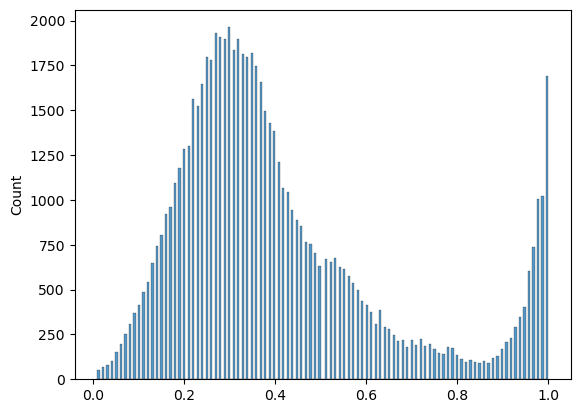

In [7]:
def predict_batch(X, knn_model):
    return knn_model.predict(X)

def predict_prob_batch(X, knn_model):
    return knn_model.predict_proba(X)

def knn_predict_par(X, knn_model, num_cores):
    X_batches = np.array_split(X, num_cores)
    with Parallel(n_jobs=num_cores, backend="threading") as parallel:
        results = parallel(delayed(predict_batch)(X_batch, knn_model) for X_batch in X_batches)
    return np.concatenate(results)

def knn_predict_prob_par(X, knn_model, num_cores):
    X_batches = np.array_split(X, num_cores)
    with Parallel(n_jobs=num_cores, backend="threading") as parallel:
        results = parallel(delayed(predict_prob_batch)(X_batch, knn_model) for X_batch in X_batches)
    return np.concatenate(results)

prob_pred = knn_predict_prob_par(c_query, knn, 72)
prob_pred_unknown = prob_pred[:, -1]
sns.histplot(data=prob_pred_unknown, bins=200)

In [8]:
progenitor = (label_gt_l1 == "Progenitor")
# sns.histplot(data=prob_pred_unknown[progenitor], bins=200)

In [9]:
f1, threshs = [], []
for thresh in np.arange(0.7, 1, 0.001):
    unknown = (prob_pred_unknown > thresh)
    f1.append(f1_score(progenitor, unknown, average='binary'))
    threshs.append(thresh)
i = np.argmax(f1)
final_f1 = {"init_model": o.init_model, "f1": f1[i], "thresh": threshs[i]}
print(final_f1)

result_dir = pj("result", "comparison", o.task, o.method, o.experiment, o.model, o.init_model)
utils.mkdirs(result_dir, remove_old=False)
utils.save_toml(final_f1, pj(result_dir, "final_f1.toml"))

{'init_model': 'sp_00003899', 'f1': 0.8032445923460899, 'thresh': 0.8300000000000001}


In [17]:
label_pred = knn.classes_[np.argmax(prob_pred[:, :-1], axis = 1)]
# label_pred[prob_pred_unknown > 0.84] = "Unknown"
label_pred[prob_pred_unknown > threshs[i]] = "Unknown" # confusion

utils.save_list_to_csv([list(line) for line in list(label_pred.reshape(-1, 1))], pj(result_dir, "label_transferred.csv"))
utils.save_list_to_csv([list(line) for line in list(label_gt_l1.reshape(-1, 1))], pj(result_dir, "label_gt.csv"))